In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install wandb

In [ ]:
from collections import namedtuple
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import PIL
import wandb

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn import metrics

In [ ]:
%env WANDB_SILENT=True
wandb.login()

env: WANDB_SILENT=True


<IPython.core.display.Javascript object>

True

In [ ]:
PROJECT_NAME = 'SVHN-CNN'
DATA_PATH = Path(f'/content/drive/MyDrive/Data/SVHN/')
DATA_PATH.mkdir(exist_ok=True)
CHECKPOINTS_PATH = Path(f'/content/drive/MyDrive/Checkpoints/{PROJECT_NAME}/')
CHECKPOINTS_PATH.mkdir(exist_ok=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Upload data


In [ ]:
trasform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.43, 0.44, 0.47],
        std=[0.20, 0.20, 0.20]
    )
])  

data_train = datasets.SVHN(
    DATA_PATH,
    split='train',
    download=True,
    transform=trasform
)
data_test = datasets.SVHN(
    DATA_PATH,
    split='test',
    download=True,
    transform=trasform
)

Using downloaded and verified file: /content/drive/MyDrive/Data/SVHN/train_32x32.mat
Using downloaded and verified file: /content/drive/MyDrive/Data/SVHN/test_32x32.mat


In [ ]:
image, target = data_train[0]
image.shape

torch.Size([3, 32, 32])

In [ ]:
data_size = data_train.data.shape[0]
validation_split = .2
split = int(validation_split * data_size)
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
len(train_indices), len(val_indices)

(58606, 14651)

In [ ]:
batch_size = 64

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    data_train, 
    batch_size=batch_size, 
    sampler=train_sampler
)
val_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=batch_size,
    sampler=val_sampler
)

In [ ]:
class AverageMeter:
    def __init__(self):
        self.count = 0
        self.sum = 0.
        self.avg = 0.
    
    def update(self, value, n=1):
        self.count += n
        self.sum += value
        self.avg = self.sum / self.count

### Train

In [ ]:
def get_best_model(checkpoints_path, run_name):
    return torch.load(checkpoints_path / f'{run_name}.pt')

In [ ]:
def compute_accuracy(model, data_loader, criterion):
    
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:

            X_gpu = X.to(device)
            y_gpu = y.to(device)

            prediction = model(X_gpu)
            loss = criterion(prediction, y_gpu)

            prediction_target = torch.argmax(prediction, axis=1)
            correct = torch.sum(prediction_target == y_gpu)
            loss_meter.update(loss.item(), 1)
            acc_meter.update(correct.item(), y_gpu.shape[0])
    
    return loss_meter.avg, acc_meter.avg

In [ ]:
def train_model(
    train_loader,
    val_loader,
    model,
    criterion,
    optimizer,
    scheduler=None,
    epochs=5,
    run_name='main',
    log=False,
    return_best=False,
    acc_treshhold=0.5
):
    if log:
        wandb.init(project=PROJECT_NAME)

    best_loss = float('inf')
    best_acc = float('inf')

    epochs_range = tqdm(range(1, epochs + 1)) if not return_best else range(1, epochs + 1)

    for epoch in epochs_range:
        
        loss_meter = AverageMeter()
        acc_meter = AverageMeter()
        
        # Train
        model.train()        
        for X, y in train_loader:

            X_gpu = X.to(device)
            y_gpu = y.to(device)

            prediction = model(X_gpu)
            loss = criterion(prediction, y_gpu)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            prediction_target = torch.argmax(prediction, axis=1)
            correct = torch.sum(prediction_target == y_gpu)
            loss_meter.update(loss.item(), 1)
            acc_meter.update(correct.item(), y_gpu.shape[0])

        # Learning rate annealing
        if scheduler is not None:
            scheduler.step()
        
        # Accuracy of validation
        val_loss, val_acc = compute_accuracy(model, val_loader, criterion)

        # Log
        if not return_best:
            print(f'epoch {epoch}/{epochs} | train_loss: {loss_meter.avg:.5f} | train_acc: {acc_meter.avg:.5f} | val_acc: {val_acc:.5f}')
        if log:
            wandb.log({'train_loss': loss_meter.avg, 'train_acc': acc_meter.avg, 'val_acc': val_acc }, step=epoch)

        # Saving model checkpoint
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_acc
            torch.save(model, CHECKPOINTS_PATH / f'{run_name}.pt')
        
        # Exiting if low accuracy
        if val_acc < acc_treshhold:
            break
    
    if log:
        wandb.finish()
    
    if return_best:
        return best_loss, best_acc

## Data augmentation

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
def visualize_samples(data, n_max=10):
    to_show = min(len(data), n_max)
    indicies = np.random.choice(range(len(data)), to_show)
    plt.figure(figsize=(22, 2))
    for i, j in enumerate(indicies):
        X = data[j][0]
        plt.subplot(1, to_show, i+1)
        plt.axis('off')
        plt.imshow(torch.moveaxis(X, 0, 2))

In [ ]:
transform_1 = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.43,0.44,0.47],
        std=[0.20,0.20,0.20]
    )                           
])

train_aug_data_1 = datasets.SVHN(
    DATA_PATH, 
    transform=transform_1
)

train_aug_loader_1 = torch.utils.data.DataLoader(
    train_aug_data_1,
    batch_size=batch_size,
    sampler=train_sampler
)

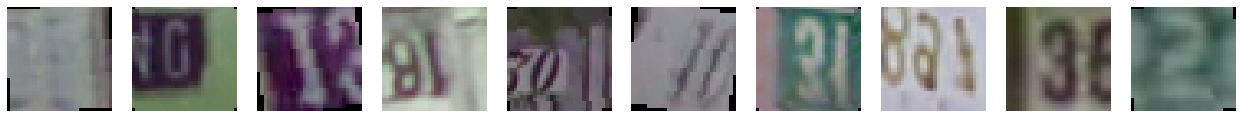

In [ ]:
transform_2 = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_aug_data_2 = datasets.SVHN(
    DATA_PATH, 
    transform=transform_2
)

visualize_samples(train_aug_data_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

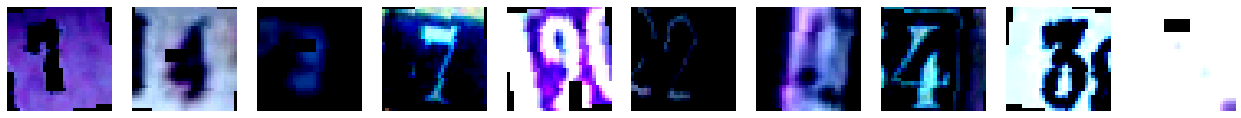

In [ ]:
transform_3 = transforms.Compose([
    transforms.ColorJitter(hue=0.3, saturation=0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomErasing(p=0.5, scale=(0.03, 0.03))
])

train_aug_data_3 = datasets.SVHN(
    DATA_PATH,
    transform=transform_3
)

train_aug_loader_3 = torch.utils.data.DataLoader(
    train_aug_data_3,
    batch_size=batch_size,
    sampler=train_sampler
)

visualize_samples(train_aug_data_3)

### CNN model

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
model1 = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(4),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(4),
    nn.Flatten(),
    nn.Linear(64*2*2, 10)
)
model1.to(device)
optimizer = optim.SGD(model1.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
train_model(train_aug_loader_3, val_loader, model1, criterion, optimizer, epochs=5, run_name='CNN-1', log=True)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1/5 | train_loss: 1.74374 | train_acc: 0.39755 | val_acc: 0.60835
epoch 2/5 | train_loss: 0.95593 | train_acc: 0.69486 | val_acc: 0.74254
epoch 3/5 | train_loss: 0.81924 | train_acc: 0.74226 | val_acc: 0.78397
epoch 4/5 | train_loss: 0.76777 | train_acc: 0.75827 | val_acc: 0.78391
epoch 5/5 | train_loss: 0.74036 | train_acc: 0.76625 | val_acc: 0.80677


# LeNet

http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf


In [ ]:
model_lenet = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.MaxPool2d(2),
    nn.Tanh(),
    nn.Conv2d(6, 16, 5),
    nn.MaxPool2d(2),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)
model_lenet.to(device)
optimizer = optim.SGD(model_lenet.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
train_model(train_aug_loader_3, val_loader, model_lenet, criterion, optimizer, epochs=5, run_name='LeNet-1', log=True)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1/5 | train_loss: 1.31756 | train_acc: 0.55356 | val_acc: 0.81476
epoch 2/5 | train_loss: 0.65201 | train_acc: 0.79647 | val_acc: 0.83523
epoch 3/5 | train_loss: 0.57541 | train_acc: 0.82147 | val_acc: 0.85366
epoch 4/5 | train_loss: 0.52939 | train_acc: 0.83560 | val_acc: 0.86622
epoch 5/5 | train_loss: 0.49812 | train_acc: 0.84343 | val_acc: 0.87680


### Validation of hyperparameters

In [ ]:
Hyperparams = namedtuple('Hyperparams', ['lr', 'reg', 'anneal_gamma'])
RunResult = namedtuple('RunResult', ['run_name', 'best_val_loss', 'best_val_acc'])

lr_choices = [1e-1, 1e-2, 1e-3, 1e-4]
reg_choices = [1e-3, 1e-4, 1e-5, 1e-7]
anneal_coeff_choices = [0.99, 0.95, 0.9, 0.8]

batch_size = 64
epochs = 10

run_record = {}

for i in tqdm(range(10)):
    lr = np.random.choice(lr_choices)
    reg = np.random.choice(reg_choices)
    anneal_coeff = np.random.choice(anneal_coeff_choices)
    run_name = f'LeNet-Validation-{i}'
    optimizer = optim.SGD(model_lenet.parameters(), lr=lr, weight_decay=reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=anneal_coeff)
    best_loss, best_acc = train_model(
        train_aug_loader_3,
        val_loader, 
        model_lenet,
        criterion,
        optimizer,
        scheduler,
        epochs=epochs,
        run_name=run_name,
        return_best=True
    )
    run_record[Hyperparams(lr, reg, anneal_coeff)] = RunResult(run_name, best_loss, best_acc)
    print(Hyperparams(lr, reg, anneal_coeff), RunResult(run_name, best_loss, best_acc))


  0%|          | 0/10 [00:00<?, ?it/s]

Hyperparams(lr=0.1, reg=1e-07, anneal_gamma=0.8) RunResult(run_name='LeNet-Validation-0', best_val_loss=0.3699975933180105, best_val_acc=0.8881987577639752)
Hyperparams(lr=0.1, reg=1e-05, anneal_gamma=0.99) RunResult(run_name='LeNet-Validation-1', best_val_loss=0.3638678716910458, best_val_acc=0.8918162582758856)
Hyperparams(lr=0.001, reg=1e-07, anneal_gamma=0.9) RunResult(run_name='LeNet-Validation-2', best_val_loss=0.3311541108129847, best_val_acc=0.9014401747321003)
Hyperparams(lr=0.0001, reg=0.0001, anneal_gamma=0.8) RunResult(run_name='LeNet-Validation-3', best_val_loss=0.3308379198200838, best_val_acc=0.9017814483652993)
Hyperparams(lr=0.1, reg=0.0001, anneal_gamma=0.9) RunResult(run_name='LeNet-Validation-4', best_val_loss=0.35252089891176036, best_val_acc=0.8970036175005119)
Hyperparams(lr=0.1, reg=1e-05, anneal_gamma=0.8) RunResult(run_name='LeNet-Validation-5', best_val_loss=0.33814578714849647, best_val_acc=0.9020544672718586)
Hyperparams(lr=0.01, reg=1e-05, anneal_gamma=0.8

In [ ]:
best_val_loss = float('inf')
best_hyperparams = None
best_run_name = None

for hyperparams, run_result in run_record.items():
    if run_result.best_val_loss < best_val_loss:
        best_val_loss = run_result.best_val_loss
        best_hyperparams = hyperparams
        best_run = run_result.run_name

print(f'Best run: {best_run}')
print(f'Best hyperparams: {best_hyperparams}')

Best run: LeNet-Validation-6
Best hyperparams: Hyperparams(lr=0.01, reg=1e-05, anneal_gamma=0.8)


In [ ]:
best_model = get_best_model(CHECKPOINTS_PATH, 'LeNet-Validation-6')

### Final test

In [ ]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
_, test_acc = compute_accuracy(best_model, test_loader, criterion)
print(f'Test accuracy: {test_acc}')

Test accuracy: 0.9025430239704979


### Visualize final test

In [ ]:
def evaluate_model(model, dataset):
    
    X_gpu = torch.Tensor(dataset.data).to(device)
    y_gpu = torch.Tensor(dataset.labels).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(X_gpu)
        prediction_target = torch.argmax(prediction, axis=1)
    
    return prediction_target.cpu(), y_gpu.cpu()

In [ ]:
prediction, gt = evaluate_model(best_model, data_test)

In [ ]:
def visualize_confusion_matrix(cm):

    size = cm.shape[0]
    fig = plt.figure(figsize=(10, 10))
    plt.title('Confusion matrix')
    plt.ylabel('Prediction')
    plt.xlabel('Ground truth')
    plot = plt.imshow(cm, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(plot)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))

    for i, j in itertools.product(range(size), range(size)):
        plt.text(j, i, cm[i][j], horizontalalignment='center')

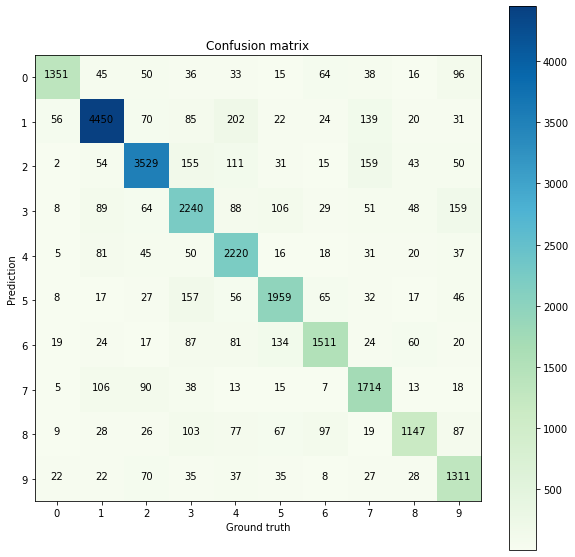

In [ ]:
cm = metrics.confusion_matrix(gt, prediction)
visualize_confusion_matrix(cm)

In [ ]:
precision = metrics.precision_score(gt, prediction, average='weighted')
recall = metrics.recall_score(gt, prediction, average='weighted')
f1 = metrics.f1_score(gt, prediction, average='weighted')

precision, recall, f1

(0.8278725935093769, 0.8232944068838353, 0.8238432899983497)

In [ ]:
def visualize_images(samples, title='', n_max=10):
    to_show = min(len(samples), n_max)
    fig = plt.figure(figsize=(20, 2))
    fig.suptitle(title)
    for i, sample in enumerate(samples[:to_show]):
        plt.subplot(1, to_show, i+1)
        plt.axis('off')
        plt.imshow(np.moveaxis(sample, 0, 2))

def visualize_predicted_actual(predicted_class, gt_class, prediction, gt, dataset):
    mask = (prediction == predicted_class) * (gt == gt_class)
    samples = dataset.data[mask]
    visualize_images(samples, title=f'Predicted: {predicted_class}')

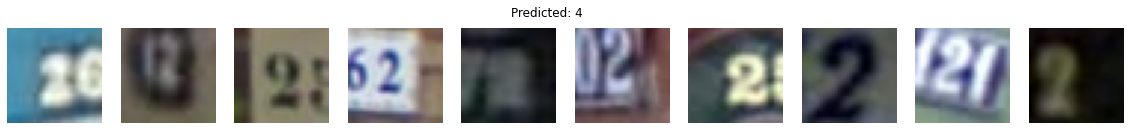

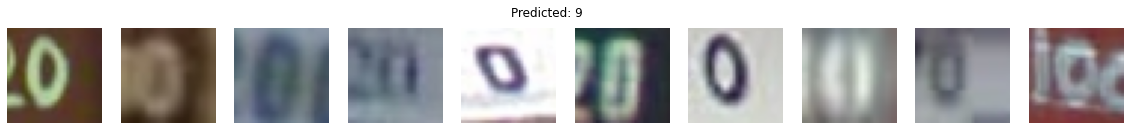

In [ ]:
visualize_predicted_actual(4, 2, prediction, gt, data_test)
visualize_predicted_actual(9, 0, prediction, gt, data_test)